In [1]:
import pandas as pd
from minicons import cwe
from torch.utils.data import DataLoader
import torch
from collections import defaultdict
from tqdm import tqdm
import re
from model import FFNModule, FeatureNormPredictor, FFNParams, TrainingParams

/home/jjr4354/.conda/envs/jwalenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# first want to clean the data
# uploading both csvs

do_df = pd.read_csv("data/refined/do_datives.csv")
po_df = pd.read_csv("data/refined/po_datives.csv")

In [3]:
# convert csvs into lists of sentence word pairs
do_list_natural = do_df[['sentence','recipient']].values.tolist()
do_list_alternate = do_df[['alternant','recipient']].values.tolist()
po_list_natural = po_df[['sentence','recipient']].values.tolist()
po_list_alternate = po_df[['alternant','recipient']].values.tolist()

In [4]:
do_list_natural[1]

['Rodolfo gives Mimi the pink bonnet he bought her, which he has kept as a souvenir of their love.',
 'mimi']

In [5]:
do_list_natural[1][1] in do_list_natural[1][0]

False

In [6]:
def _find_word_form(word, sentence):
  '''find how word occurs in sentence'''
  matches = re.finditer(word, sentence.lower())
  for match in matches:
    span = match.span()
    if (span[0] == 0 or sentence[span[0]-1] == ' ') and (span[1] == len(sentence) or sentence[span[1]] == ' ' or sentence[span[1]] == '.' or sentence[span[1]] == '!' or sentence[span[1]] == '?' or sentence[span[1]] == ',' or sentence[span[1]] == ';'):
      return tuple(span)
  return None
  print(f"no match found for {word} in {sentence}")
  raise Exception("no match found")

In [8]:
# have to convert the 'words' to spans
datasets = [do_list_natural, do_list_alternate, po_list_natural, po_list_alternate]
datasets_spans = []
for set in datasets:
    new_data = []
    for pair in set:
        sentence = pair[0]
        word = pair[1]

        # get the word's span
        wordspan = _find_word_form(word, sentence)
        if wordspan: 
            new_data.append((sentence, torch.tensor(wordspan)))
        else:
            print(f"no span found for {word} in {sentence}")
    datasets_spans.append(new_data)

no span found for em in - so kind of just toss 'em about a bit - give 'em a good old shake and then what I'm gonna do is just get 'em in the oven
no span found for em in Ah, show 'em your stuff, girl.
no span found for em in I've given 'em your word now.
no span found for the members of the sarcastic gamer community ( the forums ) in The Sarcastic Gamer Community Podcast is not a podcast, but an initiative designed to give the members of the Sarcastic Gamer Community (the forums) a chance to make their own podcast and have it featured on the site.
no span found for em in We'll buy 'em a beer.
no span found for em in Give 'em hell.
no span found for em in “I'll give 'em something to print later on, ” answered the General, grimly.
no span found for stars , in IT DRAWS ATOM TO ATOM, PARTICLE TO PARTICLE BUILDING STARS, NEBULAS,
no span found for em in Sell 'em a used phone.
no span found for em in - so kind of just toss 'em about a bit - give a good old shake to 'em and then what I'm gonn

In [9]:
"the members of the sarcastic gamer community (the forums)" in "The Sarcastic Gamer Community Podcast is not a podcast, but an initiative designed to give the members of the Sarcastic Gamer Community (the forums) a chance to make their own podcast and have it featured on the site.".lower()

True

In [20]:
for set in datasets_spans:
    print(len(set))

1230
1230
968
985


In [21]:
# make all datasets the same length
min_length = min([len(set) for set in datasets_spans])

datasets_spans_trunc = [set[:min_length] for set in datasets_spans]

In [22]:
for set in datasets_spans_trunc:
    print(len(set))

968
968
968
968


In [23]:
# extract all the embeddings and do predictions
lms = ['roberta-base', 'bert-base-uncased', 'albert-xxlarge-v2']
# hierarchy is model: dataset: layer: average feature prediction vector
preds_per_model = {'bert-base-uncased': [], 'albert-xxlarge-v2': [], 'roberta-base': []}
num_features = 65 # binder
for model in lms:
    # load lm for embedding extraction
    lm = cwe.CWE(model)
    # load my models
    nick_name = str.split(model, "-")[0]
    classifiers = []
    for layer in range(13):
        path = f"../saved_models/{nick_name}_models_all/{nick_name}_to_binder_layer{layer}.ckpt"
        my_mo = FeatureNormPredictor.load_from_checkpoint(
            checkpoint_path=path,
            map_location={"cuda:1":"cpu", "cuda:2":"cpu"}
        )
        my_mo.eval()
        classifiers.append(my_mo)
    
    for set in datasets_spans_trunc:
        # initialize a dictionary for our predictions to live in
        layerwise_predictions = defaultdict(lambda : torch.zeros(num_features).unsqueeze(0))

        dl = DataLoader(set, batch_size=16)
        # tqdm is progress bar
        for batch in tqdm(dl):
            sentences, words = batch
            batched_query = list(zip(sentences, words))
            # we have a 3d tensor: layer: sentence: embedding
            layer_embs = lm.extract_representation(batched_query, layer='all')
            for layer, embs in enumerate(layer_embs):
                for i in range(0, embs.size(0)):
                    emb = embs[i]
                    # this is a nan check
                    if layer == 0:
                        query = batched_query[i]
                        if emb.isnan().any():
                            print("nan detected in extracted embeddings, offending query:")
                            print(f"query: {query}")
                            raise Exception("nan found in embedding")
                    # perform prediction on this embedding
                    my_mo = classifiers[layer]
                    with torch.no_grad(): pred = torch.nn.functional.relu(my_mo(emb))
                    pred = pred.squeeze(0)
                    # add this to the calculation
                    layerwise_predictions[layer] += (pred/len(set))

        layerwise_predictions = dict(layerwise_predictions)
        preds_per_model[model].append(layerwise_predictions)


100%|██████████| 61/61 [02:47<00:00,  2.74s/it]


In [24]:
# checking that structure is as expected
# embs_per_model[model][dataset][layer] should give a 1 d vector
preds_per_model['bert-base-uncased'][3][8].detach().tolist()[0]

[3.1263058185577393,
 0.6799095273017883,
 0.500452995300293,
 1.0161296129226685,
 1.0844590663909912,
 1.3283034563064575,
 0.9219702482223511,
 1.3604971170425415,
 1.888251543045044,
 0.6702268719673157,
 0.6407505869865417,
 2.112161636352539,
 1.2029523849487305,
 1.5511987209320068,
 1.7887256145477295,
 1.1564773321151733,
 0.5331286787986755,
 1.1209218502044678,
 1.621564507484436,
 0.5256428718566895,
 1.1638153791427612,
 0.6866170763969421,
 0.3210582733154297,
 0.4191788136959076,
 1.0733232498168945,
 0.41498517990112305,
 1.4586948156356812,
 0.36075371503829956,
 0.7377455234527588,
 0.9297122359275818,
 1.3063013553619385,
 0.6738399267196655,
 1.4473121166229248,
 0.9295790195465088,
 0.5510575175285339,
 1.7369216680526733,
 1.2933363914489746,
 0.5370705127716064,
 0.42298465967178345,
 0.7372128963470459,
 0.710139811038971,
 0.8861730694770813,
 0.9386451840400696,
 0.536830484867096,
 1.0070712566375732,
 1.275635004043579,
 1.4965977668762207,
 1.57853043079376

In [2]:
label_path = "../saved_models/bert_models_all/bert_to_binder_layer8.txt"
with open (label_path, "r") as file:
    labels = [line.rstrip() for line in file.readlines()]
lms = ['albert-xxlarge-v2', 'bert-base-uncased', 'roberta-base']

In [26]:
# experimentation

# data = pd.DataFrame({
#     "feature": labels,
#     "DO_natural": preds_per_model['bert-base-uncased'][0][8].detach().tolist()[0],
#     "DO_alter": preds_per_model['bert-base-uncased'][1][8].detach().tolist()[0],
#     "PO_natural": preds_per_model['bert-base-uncased'][2][8].detach().tolist()[0],
#     "PO_alter": preds_per_model['bert-base-uncased'][3][8].detach().tolist()[0],
# })
# data.loc[:,'DO_change'] = data["DO_alter"] - data["DO_natural"]
# data.loc[:,'PO_change'] = data["PO_alter"] - data["PO_natural"]
# data.loc[:,'natural_diff'] = (data["DO_natural"] - data["PO_natural"]).abs()
# data.loc[:,'avg_diff_mag'] = (data["DO_change"].abs() + data["PO_change"].abs())/2

# data.loc[:,'center_val'] = (data["DO_natural"] + data["PO_natural"])/2
# data.loc[:,'DO_nat_center'] = data["DO_natural"] - data["center_val"]
# data.loc[:,'PO_nat_center'] = data["PO_natural"] - data["center_val"]
# data.head()

In [27]:
# a loop to save data in csvs
for model in lms:
    nick_name = str.split(model, "-")[0]
    for layer in range(13):
        data = pd.DataFrame({
            "feature": labels,
            "DO_natural": preds_per_model[model][0][layer].detach().tolist()[0],
            "DO_alter": preds_per_model[model][1][layer].detach().tolist()[0],
            "PO_natural": preds_per_model[model][2][layer].detach().tolist()[0],
            "PO_alter": preds_per_model[model][3][layer].detach().tolist()[0],
        })
        data.loc[:,'DO_change'] = data["DO_alter"] - data["DO_natural"]
        data.loc[:,'PO_change'] = data["PO_alter"] - data["PO_natural"]
        data.loc[:,'natural_diff'] = (data["DO_natural"] - data["PO_natural"]).abs()
        data.loc[:,'avg_diff_mag'] = (data["DO_change"].abs() + data["PO_change"].abs())/2

        data.loc[:,'center_val'] = (data["DO_natural"] + data["PO_natural"])/2
        data.loc[:,'DO_nat_center'] = data["DO_natural"] - data["center_val"]
        data.loc[:,'PO_nat_center'] = data["PO_natural"] - data["center_val"]

        data.to_csv(f'results/refined/csvs/{nick_name}{layer}.csv')

In [3]:
# data vis time ヾ(⌐■_■)ノ♪
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
%matplotlib inline

#set font size of labels on matplotlib plots
plt.rc('font', size=16)

#set style of plots
sns.set_style('white')

   Unnamed: 0    feature  DO_natural  DO_alter  PO_natural  PO_alter  \
0          10       Slow    0.648109  0.650093    0.658761  0.640751   
1          56        Sad    0.467695  0.490501    0.612624  0.609743   
2          57      Angry    0.451745  0.436618    0.516863  0.528078   
3          22        Low    0.363828  0.343013    0.312119  0.321058   
4          58  Disgusted    0.363188  0.390813    0.425468  0.428579   

   DO_change  PO_change  natural_diff  avg_diff_mag  center_val  \
0   0.001983  -0.018010      0.010652      0.009997    0.653435   
1   0.022806  -0.002881      0.144929      0.012843    0.540159   
2  -0.015127   0.011215      0.065119      0.013171    0.484304   
3  -0.020815   0.008939      0.051710      0.014877    0.337974   
4   0.027625   0.003111      0.062280      0.015368    0.394328   

   DO_nat_center  PO_nat_center  
0      -0.005326       0.005326  
1      -0.072464       0.072464  
2      -0.032559       0.032559  
3       0.025855      -0.025

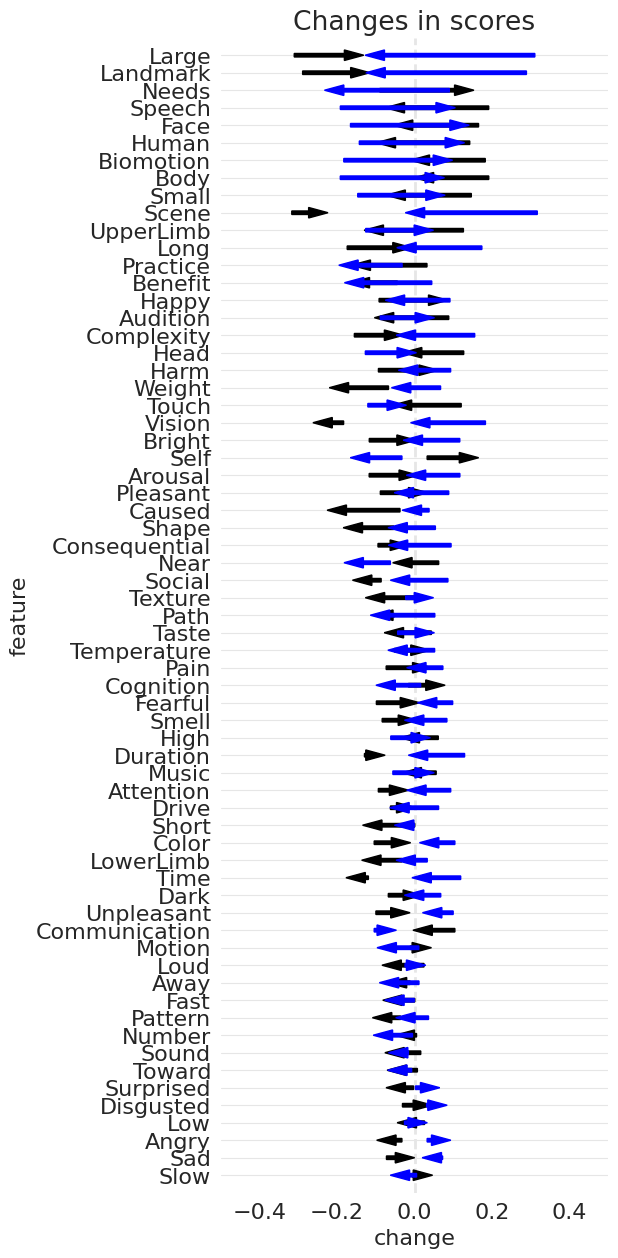

In [29]:
# experimentation
k = num_features
data = pd.read_csv("results/refined/csvs/bert8.csv")
#sort features by amount of change, from largest to smallest
data = data.sort_values(by='avg_diff_mag', ascending=True) \
           .reset_index(drop=True).tail(k)

data = data.sort_values(by='avg_diff_mag', ascending=True) \
           .reset_index(drop=True).tail(k)

print(data.head())
#initialize a plot
fig, ax = plt.subplots(figsize=(5,15))
ax.set_xlim(-0.5,0.5)
ax.set_ylim(-1,k)
ax.set_yticks(range(k))
ax.set_yticklabels(data['feature'])

#define arrows
arrow_starts_DO = data['DO_nat_center']
arrow_starts_PO = data['PO_nat_center']
arrow_lengths_DO = data['DO_change'].values
arrow_lengths_PO = data['PO_change'].values

#add arrows to plot
for i, subject in enumerate(data['feature']):
    # DO arrows
    ax.arrow(arrow_starts_DO[i],        #x start point
             i,                      #y start point
             arrow_lengths_DO[i],       #change in x 
             0,                      #change in y
             head_width=0.6,         #arrow head width
             head_length=0.05,        #arrow head length
             width=0.2,              #arrow stem width
             fc='black',             #arrow fill color
             ec='black')             #arrow edge color
    ax.arrow(arrow_starts_PO[i],        #x start point
             i,                      #y start point
             arrow_lengths_PO[i],       #change in x 
             0,                      #change in y
             head_width=0.6,         #arrow head width
             head_length=0.05,        #arrow head length
             width=0.2,              #arrow stem width
             fc='blue',             #arrow fill color
             ec='blue')             #arrow edge color

#format plot
ax.set_title('Changes in scores')                     #add title
ax.axvline(x=0, color='0.9', ls='--', lw=2, zorder=0) #add line at x=0
ax.grid(axis='y', color='0.9')                        #add a light grid
ax.set_xlim(-0.5,0.5)                                     #set x axis limits
ax.set_xlabel('change')                               #label the x axis
ax.set_ylabel('feature')                          #label the y axis
sns.despine(left=True, bottom=True)                   #remove axes

In [4]:
# from intuition

humany_things = {"Biomotion", "Body", "Human", "Face", "Speech", "Motion", "Head"}
inanimate_things = {"Vision", "Landmark", "Scene", "Large"}

In [59]:
# a loop to datavis for all 39 models
def do_plots(dir,figsize, plot_do=True, plot_po=True, k=num_features, filter_animate = False, filter_inanimate=False):
    for model in lms:
        nick_name = str.split(model, "-")[0]
        for layer in range(13):
            if plot_do:
                sortby = 'DO_change'
            else:
                sortby = 'PO_change'
            data = pd.read_csv(f"results/refined/csvs/{nick_name}{layer}.csv")

            # filter if necessary
            if filter_animate and filter_inanimate:
                filter = humany_things.union(inanimate_things)
                data = data[data['feature'].isin(filter)]
                k = len(filter)
                # print(filter)
                # print(data['feature'])
            elif filter_animate:
                data = data[data['feature'].isin(humany_things)]
                k = len(humany_things)
            elif inanimate_things:
                data = data[data['feature'].isin(inanimate_things)]
                k = len(inanimate_things)
            
            #sort features by amount of change, from largest to smallest
            data = data.sort_values(by=sortby, ascending=True) \
            .reset_index(drop=True).tail(k)
            
            data = data.sort_values(by=sortby, ascending=True) \
            .reset_index(drop=True).tail(k)

            #initialize a plot
            fig, ax = plt.subplots(figsize=figsize)
            ax.set_xlim(-0.5,0.5)
            ax.set_ylim(-1,k)
            ax.set_yticks(range(k))
            ax.set_yticklabels(data['feature'])

            #define arrows
            arrow_starts_DO = data['DO_nat_center'].values
            arrow_starts_PO = data['PO_nat_center'].values
            arrow_lengths_DO = data['DO_change'].values
            arrow_lengths_PO = data['PO_change'].values

            #add arrows to plot
            for i, subject in enumerate(data['feature']):
                # DO arrows
                if plot_do:
                    ax.arrow(arrow_starts_DO[i],        #x start point
                            i,                      #y start point
                            arrow_lengths_DO[i],       #change in x 
                            0,                      #change in y
                            head_width=0.6,         #arrow head width
                            head_length=0.05,        #arrow head length
                            width=0.2,              #arrow stem width
                            fc='black',             #arrow fill color
                            ec='black')             #arrow edge color
                if plot_po:
                    ax.arrow(arrow_starts_PO[i],        #x start point
                            i,                      #y start point
                            arrow_lengths_PO[i],       #change in x 
                            0,                      #change in y
                            head_width=0.6,         #arrow head width
                            head_length=0.05,        #arrow head length
                            width=0.2,              #arrow stem width
                            fc='blue',             #arrow fill color
                            ec='blue')             #arrow edge color

            #format plot
            ax.set_title(f"{nick_name} layer {layer}")                     #add title
            ax.axvline(x=0, color='0.9', ls='--', lw=2, zorder=0) #add line at x=0
            ax.grid(axis='y', color='0.9')                        #add a light grid
            ax.set_xlim(-0.5,0.5)                                     #set x axis limits
            ax.set_xlabel('change')                               #label the x axis
            ax.set_ylabel('feature')                          #label the y axis
            sns.despine(left=True, bottom=True)                   #remove axes

            plt.tight_layout()
            plt.savefig(f"{dir}/{nick_name}{layer}.png")
            plt.close()

In [31]:
# plot all the stuff
do_plots("results/refined/all_features/all",(5,15))
# plot all the features but only for po and do
do_plots("results/refined/all_features/just_do",(5,15), plot_po=False)
do_plots("results/refined/all_features/just_po",(5,15), plot_do=False)

In [58]:
do_plots("results/refined/ani_features",(5,10), filter_big_diff=True, filter_big_shift=True)

In [60]:
do_plots("results/refined/all_features/all/by_do",(5,15))

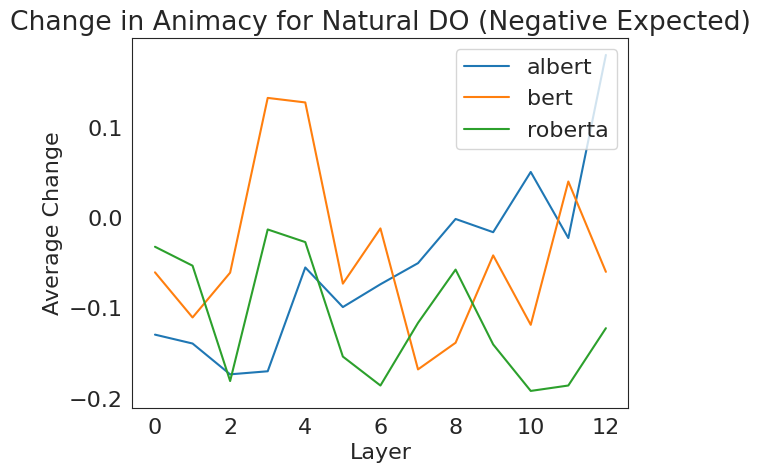

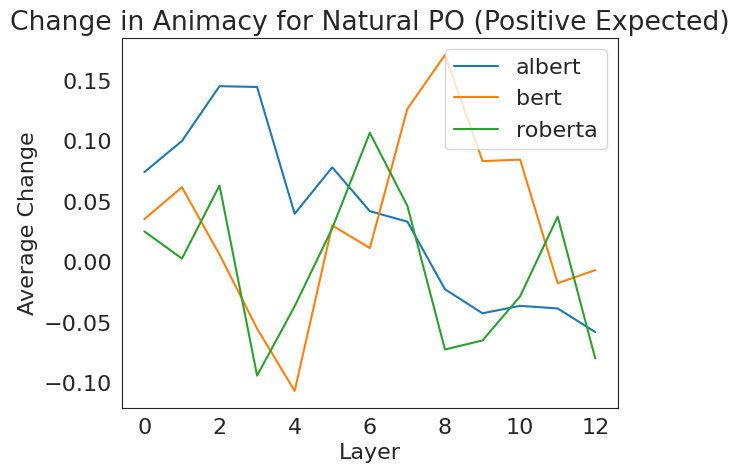

In [25]:
# calculate metric : humany shift experimentation
do_values = defaultdict(list)
po_values = defaultdict(list)
for model in lms:
    nick_name = str.split(model, "-")[0]
    for layer in range(13):
        data = pd.read_csv(f"results/refined/csvs/{nick_name}{layer}.csv")
        # filter for just the humany things
        data = data[data['feature'].isin(humany_things)]
        # find the mean of the change for DO and PO
        do_values[nick_name].append(data.loc[:, 'DO_change'].mean())
        po_values[nick_name].append(data.loc[:, 'PO_change'].mean())

plt.figure()
for model in lms:
    nick_name = str.split(model, "-")[0]
    plt.plot(list(range(13)),do_values[nick_name], label = nick_name)
plt.legend()
plt.title("Change in Animacy for Natural DO (Negative Expected)")
plt.ylabel("Average Change")
plt.xlabel("Layer")
plt.show()
plt.close()
plt.figure()
for model in lms:
    nick_name = str.split(model, "-")[0]
    plt.plot(list(range(13)),po_values[nick_name], label = nick_name)
plt.legend()
plt.title("Change in Animacy for Natural PO (Positive Expected)")
plt.ylabel("Average Change")
plt.xlabel("Layer")
plt.show()
plt.close()

In [ ]:
for thing in humany_things:
    # calculate metric : humany shift experimentation
    do_values = defaultdict(list)
    po_values = defaultdict(list)
    for model in lms:
        nick_name = str.split(model, "-")[0]
        for layer in range(13):
            data = pd.read_csv(f"results/refined/csvs/{nick_name}{layer}.csv")
            # filter for just the humany things
            data = data[data['feature']== thing]
            # find the mean of the change for DO and PO
            do_values[nick_name].append(data.loc[:, 'DO_change'].mean())
            po_values[nick_name].append(data.loc[:, 'PO_change'].mean())

    plt.figure()
    for model in lms:
        nick_name = str.split(model, "-")[0]
        plt.plot(list(range(13)),do_values[nick_name], label = nick_name)
    plt.legend()
    plt.title("Change in Animacy for Natural DO (Negative Expected)")
    plt.ylabel("Average Change")
    plt.xlabel("Layer")
    plt.savefig(f"results/refined/overall/by_feature/do/{thing}.png")
    plt.close()
    plt.figure()
    for model in lms:
        nick_name = str.split(model, "-")[0]
        plt.plot(list(range(13)),po_values[nick_name], label = nick_name)
    plt.legend()
    plt.title("Change in Animacy for Natural PO (Positive Expected)")
    plt.ylabel("Average Change")
    plt.xlabel("Layer")
    plt.savefig(f"results/refined/overall/by_feature/po/{thing}.png")
    plt.close()


In [20]:
candidates = ["albert2", "albert3", "bert7", "bert8", "roberta6"]

for candidate in candidates:
    data = pd.read_csv(f"results/refined/csvs/{candidate}.csv")

    # filter for the ones we're interested in
    filter = humany_things.union(inanimate_things)
    data = data[data['feature'].isin(filter)]
    k = len(filter)
    #sort features by amount of change, from largest to smallest
    data = data.sort_values(by='DO_change', ascending=True) \
    .reset_index(drop=True).tail(k)
    
    data = data.sort_values(by='DO_change', ascending=True) \
    .reset_index(drop=True).tail(k)

    #initialize a plot
    fig, ax = plt.subplots(figsize=(7,7))
    ax.set_xlim(-0.5,0.5)
    ax.set_ylim(-1,k)
    ax.set_yticks(range(k))
    ax.set_yticklabels(data['feature'])

    #define arrows
    arrow_starts_DO = data['DO_nat_center'].values
    arrow_starts_PO = data['PO_nat_center'].values
    arrow_lengths_DO = data['DO_change'].values
    arrow_lengths_PO = data['PO_change'].values

    #add arrows to plot
    for i, subject in enumerate(data['feature']):
        # DO arrows
        ax.arrow(arrow_starts_DO[i],        #x start point
                i,                      #y start point
                arrow_lengths_DO[i],       #change in x 
                0,                      #change in y
                head_width=0.6,         #arrow head width
                head_length=0.05,        #arrow head length
                width=0.2,              #arrow stem width
                fc='black',             #arrow fill color
                ec='black')             #arrow edge color
        # PO_arrows
        ax.arrow(arrow_starts_PO[i],        #x start point
                i,                      #y start point
                arrow_lengths_PO[i],       #change in x 
                0,                      #change in y
                head_width=0.6,         #arrow head width
                head_length=0.05,        #arrow head length
                width=0.2,              #arrow stem width
                fc='blue',             #arrow fill color
                ec='blue')             #arrow edge color

    #format plot
    ax.set_title(candidate)                     #add title
    ax.axvline(x=0, color='0.9', ls='--', lw=2, zorder=0) #add line at x=0
    ax.grid(axis='y', color='0.9')                        #add a light grid
    ax.set_xlim(-0.5,0.5)                                     #set x axis limits
    ax.set_xlabel('change')                               #label the x axis
    ax.set_ylabel('feature')                          #label the y axis
    sns.despine(left=True, bottom=True)                   #remove axes
    plt.legend(["Natural DO", "Natural PO"], loc="lower right")

    plt.tight_layout()
    plt.savefig(f"results/refined/overall/{candidate}.png")
    plt.close()